In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.optimize import curve_fit

In [2]:
from utils.layers import filter_creation

In [3]:
from matplotlib.colors import ListedColormap, BoundaryNorm

# colors = ['#EFB475', '#477081', '#AEC5FB', '#F77B7F']
colors = ['#EFB475', '#477081', '#F0F3FC', '#F77B7F']
cmap = ListedColormap(colors)
bounds = [-1.5, -0.5, 0.5, 1.5, 2.5]
norm = BoundaryNorm(bounds, cmap.N)

In [4]:
from matplotlib import font_manager

font_path = '../Ruda/Ruda-VariableFont_wght.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

In [13]:
camada = filter_creation(tamanho_rede = 200,
                porosidade = .2,
                camadas = 1,
                diametro_fibra = 3,
                concentracao_cbm = 0.1,
                tamanho_cbm = 1,
                CBM=True,
                display=False)[0]

Filtro criado, 0.16


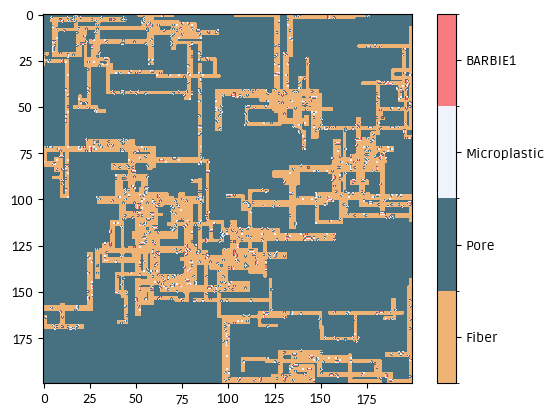

In [14]:
cax = plt.imshow(camada, cmap=cmap, norm=norm)
# plt.xticks([])
# plt.yticks([])

cbar = plt.colorbar(cax, ticks=[-1,0,1,2])
cbar.set_ticklabels(['Fiber', 'Pore', 'Microplastic', 'BARBIE1'])

# plt.tight_layout()
# plt.xlim(0,100)
# plt.ylim(0,100)
plt.savefig('results/filter/filter_control.png',transparent=True,dpi=700)
# plt.show()

# cax = plt.imshow(camada, cmap=cmap, norm=norm)
# cbar = plt.colorbar(cax, ticks=[-1,0,1,2])
# cbar.set_ticklabels(['Fiber', 'Pore', 'Microplastic', 'BARBIE1'])
# plt.xticks([])
# plt.yticks([])
# plt.tight_layout()
# # plt.savefig('results/filter/zoomed_filter_control_w_cbm.png',transparent=True,dpi=700)
# plt.show()

In [6]:
camada = filter_creation(tamanho_rede = 100,
                porosidade = 0.8,
                camadas = 1,
                diametro_fibra = 3,
                concentracao_cbm = 0.1,
                tamanho_cbm = 1,
                CBM=True,
                display=False)[0]

Filtro criado, 0.07


In [7]:
def calcular_energia(rede):
    energia = 0
    tamanho = len(rede)
    for i in range(tamanho):
        for j in range(tamanho):
            S = rede[i, j]
            if S == 0:
                continue

            # Interacao Vizinhos
            vizinhos = [
                rede[(i+1) % tamanho, j],
                rede[i, (j+1) % tamanho],
                rede[(i-1) % tamanho, j],
                rede[i, (j-1) % tamanho]
            ]

            
            for V in vizinhos:
                if S == 1:  # CBM
                    if V == -1:  # CBM com MP
                        energia += E_CBMP
                    elif V == 2:  # CBM com espid
                        energia += E_CBMS
                    elif V == 1:  # CBM com CBM
                        energia += E_CBMCBM
                elif S == 2:  # Espid
                    if V == -1:  # Espid com MP
                        energia += E_SMP
                    elif V == 2:  # Espid com espid
                        energia += E_SS
                elif S == -1:  # MP
                    if V == -1:  # MP com MP
                        energia += E_MPMP
    
    # return energia/(len(rede)**2)
    return energia/2

In [12]:
def monte_carlo(rede, mps_count, passos, T, tamanho_limite_mp=50):
    
    tamanho = len(rede)
    mps_size = []
    
    for passo in range(passos):
        
        # Posicao aleatoria na rede
        i = np.random.randint(0, tamanho)
        j = np.random.randint(0, tamanho)
        tamanho_mp = np.random.randint(0, tamanho_limite_mp)
        S = rede[i, j]
        
        rede_teste = rede.copy()

        kB=1
        beta = kB*T

        # Boundary
        if i+tamanho_mp < tamanho and j+tamanho_mp < tamanho:
            
            rede_teste[i:i+tamanho_mp,j:j+tamanho_mp] = 1

            energia_atual = calcular_energia(rede)
            energia_teste = calcular_energia(rede_teste)
            
            energia_atual = np.exp(-beta*(-energia_atual))
            energia_teste = np.exp(-beta*(-energia_teste))

            # delta_energia = energia_teste - energia_atual
            # if np.random.rand() >= np.exp(-delta_energia / T):
            # print(delta_energia,np.exp(-delta_energia/T))

            # ALGORITMO DE METROPOLES
            # EXISTE CHANCE DE MANTER O SISTEMA
            # MESMO QUE A ENERGIA NÃO FOR MENOR

            if energia_teste > energia_atual:
                rede[i:i+tamanho_mp,j+j:tamanho_mp] = S
            elif np.random.random() < 0.3:
                rede[i:i+tamanho_mp,j+j:tamanho_mp] = S
            else:
                mps_count += 1
                mps_size.append(tamanho_mp)
                rede = rede_teste
    
    return rede,mps_count,mps_size

In [13]:
E_CBMP = -0.69
E_CBMS = -0.1
E_SMP = -0.24
E_CBMCBM = -0.1
E_SS = -0.1
E_MPMP = -0.1

In [14]:
it = 100
e_config = {}
energias,mps_list,mps_size_list = [],[],[]

for n in range(it):

    mps_count = 0

    rede,mps_count,mps_size = monte_carlo(camada, mps_count, passos=20, tamanho_limite_mp=5, T=300)
    energia_atual = calcular_energia(rede)

    mps_size_list.append(mps_size)

    energias.append(energia_atual)
    mps_list.append(mps_count)

    e_config.update({n:[energia_atual,rede]})

In [22]:
bins_dic = {}
for i in range(1,len(bins)):
    bins_dic[f'{round(bins[i-1],4)} - {round(bins[i],4)}'] = []

for ec in e_config.values():
    for k in bins_dic.keys():
        splitted = k.split(' - ')
        min_lim = float(splitted[0]) 
        max_lim = float(splitted[1])
        if ec[0] >= min_lim and ec[0] <= max_lim:
            bins_dic[k].append(ec[1])

def calculate_rmsd(A, B):
    dif = A - B
    rmsd = np.sqrt(np.mean(np.sum(dif**2, axis=1)))
    return rmsd

rmsd_vals = []

for k,v in bins_dic.items():
    
    rmsd_results = []
    matrices = v.copy()

    for (i, j) in combinations(range(len(matrices)), 2):
        rmsd = calculate_rmsd(matrices[i], matrices[j])
        rmsd_results.append(rmsd)
    
    if len(rmsd_results) > 0:
        rmsd_vals.append(np.mean(rmsd_results))
    else:
        rmsd_vals.append(0)

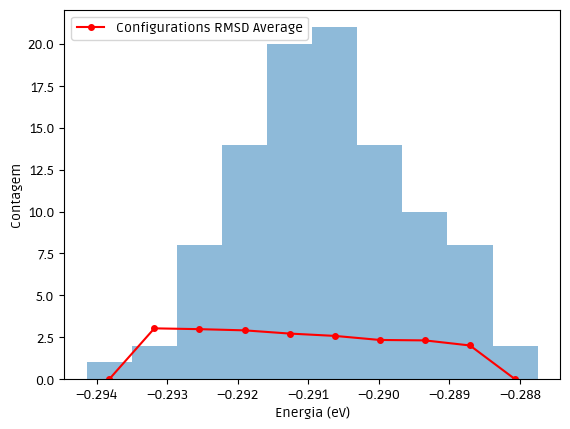

In [25]:
count, bins, _ = plt.hist(energias,density=False,alpha=0.5)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

plt.plot(bin_centers,rmsd_vals,marker='o',markersize=4,color='red',label='Configurations RMSD Average')

# def gaussian(x, amplitude, mean, stddev):
#     return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

# popt, pcov = curve_fit(gaussian, bin_centers, count)
# plt.plot(bin_centers, gaussian(bin_centers, *popt), 'r-', label='Gaussian Fit')

plt.legend()
plt.xlabel('Energia (eV)'),plt.ylabel('Contagem')

plt.show()

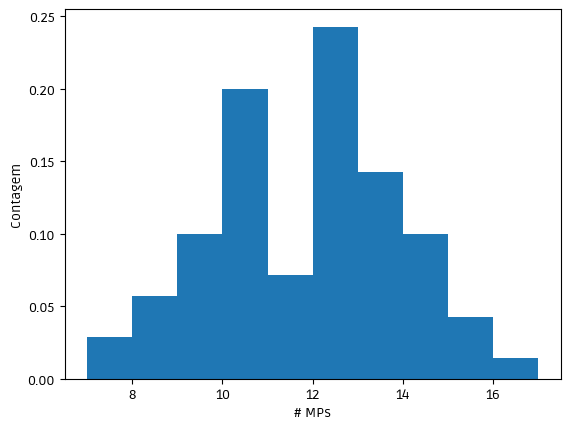

In [22]:
plt.hist(mps_list,density=True)
plt.xlabel('# MPs'),plt.ylabel('Contagem')
plt.show()

In [64]:
avg_list,std_list = [],[]
for mps_size in mps_size_list:
    avg = np.mean(mps_size)
    std = np.array(mps_size).std()
    standard_error = std / np.sqrt(len(mps_size))
    avg_list.append(avg),std_list.append(standard_error)

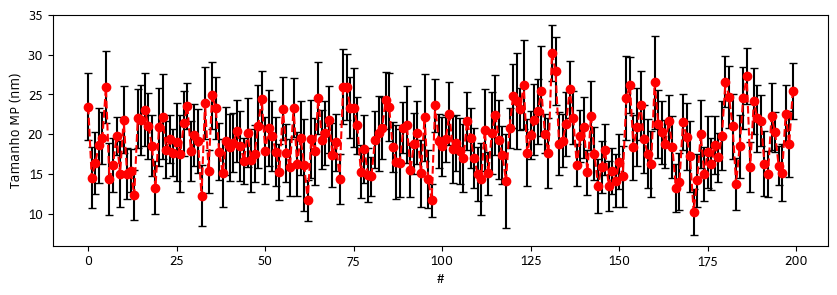

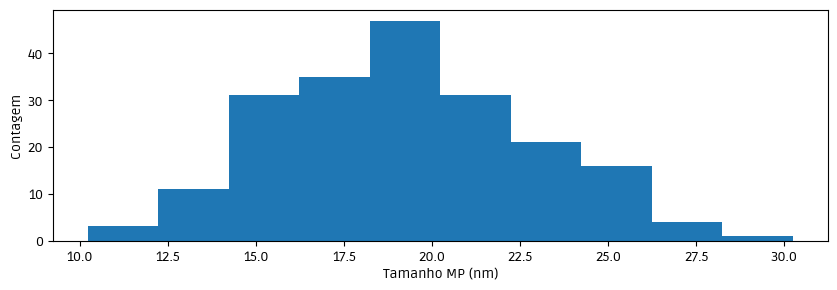

In [65]:
plt.figure(figsize=(10,3))
plt.errorbar(range(len(avg_list)),avg_list,yerr=std_list,capsize=3,fmt="r--o",ecolor = "black")
plt.xlabel('#'),plt.ylabel('Tamanho MP (nm)')
plt.show()

plt.figure(figsize=(10,3))
plt.hist(avg_list)
plt.xlabel('Tamanho MP (nm)'),plt.ylabel('Contagem')
plt.show()

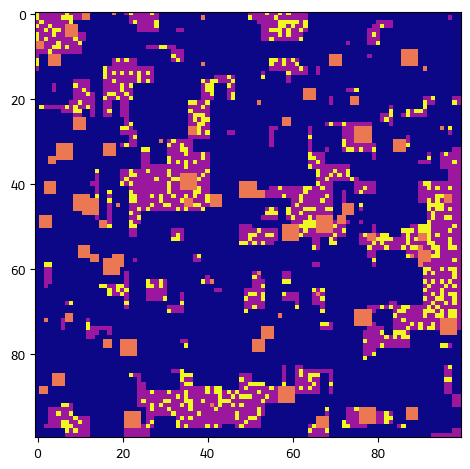

In [131]:
plt.imshow(e_config[0][1],cmap='plasma')
plt.tight_layout()
# plt.savefig('results/simulation/zoomed_filter_control.png',transparent=True,dpi=700)
plt.show()

In [112]:
e_config

{0: [-0.2990939999998421,
  array([[ 2,  0,  0, ..., -1, -1, -1],
         [ 2,  0,  0, ...,  0, -1, -1],
         [ 0,  2,  0, ..., -1, -1, -1],
         ...,
         [-1, -1,  0, ..., -1, -1, -1],
         [-1, -1, -1, ..., -1,  0,  0],
         [-1, -1, -1, ...,  0,  0,  0]])],
 1: [-0.29634199999984195,
  array([[ 2,  0,  0, ..., -1, -1, -1],
         [ 2,  0,  0, ...,  0, -1, -1],
         [ 0,  2,  0, ..., -1, -1, -1],
         ...,
         [-1, -1,  0, ..., -1, -1, -1],
         [-1, -1, -1, ..., -1,  0,  0],
         [-1, -1, -1, ...,  0,  0,  0]])],
 2: [-0.2997269999998404,
  array([[ 2,  0,  0, ..., -1, -1, -1],
         [ 2,  0,  0, ...,  0, -1, -1],
         [ 0,  2,  0, ..., -1, -1, -1],
         ...,
         [-1, -1,  0, ..., -1, -1, -1],
         [-1, -1, -1, ..., -1,  0,  0],
         [-1, -1, -1, ...,  0,  0,  0]])],
 3: [-0.2988969999998447,
  array([[ 2,  0,  0, ..., -1, -1, -1],
         [ 2,  0,  0, ...,  0, -1, -1],
         [ 0,  2,  0, ..., -1, -1, -1],
    